In [1]:
import numpy as np
import scipy as sp
import scipy.sparse.linalg as spsplin
import scipy.sparse as spsp
import matplotlib.pyplot as plt
import networkx as nx
plt.rc("text", usetex=True)
%config InlineBackend.figure_format = 'retina'

In [2]:
import networkx as nx
from collections import defaultdict
import pickle
import collections
from tqdm import tqdm, tnrange, tqdm_notebook

In [138]:
# INPUT:  G - np.ndarray or sparse matrix
# OUTPUT: A - np.ndarray (of size G.shape) or sparse matrix
def pagerank_matrix(G):
    return G.multiply(1 / G.sum(axis=0))

# INPUT:  A - np.ndarray (2D), x0 - np.ndarray (1D), num_iter - integer (positive)
# OUTPUT: x - np.ndarray (of size x0), l - float, res - np.ndarray (of size num_iter + 1 [include initial guess])
def power_method(A, x0, num_iter):
    x = x0
    res = []
    for _ in range(num_iter):
        l = x.T.dot(A.dot(x)) / x.T.dot(x)
        x_new = A.dot(x)
        x_new = x_new / np.linalg.norm(x_new)
        res.append(np.linalg.norm(x - x_new))
        x = x_new
    return x, l, res

# INPUT:  A - np.ndarray (2D), d - float (from 0.0 to 1.0), x - np.ndarray (1D, size of A.shape[0/1])
# OUTPUT: y - np.ndarray (1D, size of x)
def pagerank_matvec(A, d, x):
    y = d * A.dot(x) + (1 - d) / A.shape[0] * x.sum()
    return y

In [139]:
N = 100
density = 0.5
G = sp.sparse.random(N, N, density, format='csr')

In [140]:
G = np.array([[0, 0, 0, 1],
             [1, 0, 0, 0],
             [1, 1, 0, 0],
             [0, 0, 1, 0]])
G = sp.sparse.csr_matrix(G)

In [141]:
e, v = spsplin.eigs(G.toarray())
e, v

(array([ 1.22074408+0.j        , -0.24812606+1.03398206j,
        -0.24812606-1.03398206j, -0.72449196+0.j        ]),
 array([[-0.43105035+0.j        , -0.43004841+0.21901058j,
         -0.43004841-0.21901058j, -0.51948488+0.j        ],
        [-0.3531046 +0.j        ,  0.29465245+0.34520662j,
          0.29465245-0.34520662j,  0.71703333+0.j        ],
        [-0.64235818+0.j        ,  0.54567408+0.j        ,
          0.54567408-0.j        , -0.27267169+0.j        ],
        [-0.52620216+0.j        , -0.1197468 -0.49900457j,
         -0.1197468 +0.49900457j,  0.37636262+0.j        ]]))

In [142]:
A = pagerank_matrix(G)
d = 0.85
L = spsplin.LinearOperator(A.shape, matvec=lambda x: pagerank_matvec(A, d, x))

# Ad = d * A + (1 - d) / N * np.ones((N, N))
# assert np.isclose(pagerank_matvec(A, d, x), Ad.dot(x)).all()

In [145]:
%%time
p = np.zeros(A.shape[0])
s = G.sum(axis=0).argmax()
p[s] = 1

num_iter = 50
x, l, res = power_method(L, p, num_iter)
x /= x.sum()

CPU times: user 26.5 ms, sys: 5.75 ms, total: 32.2 ms
Wall time: 27.9 ms


eigenvector: [0.27665878 0.15507998 0.28689797 0.28136327] eigenvalue: 1.0


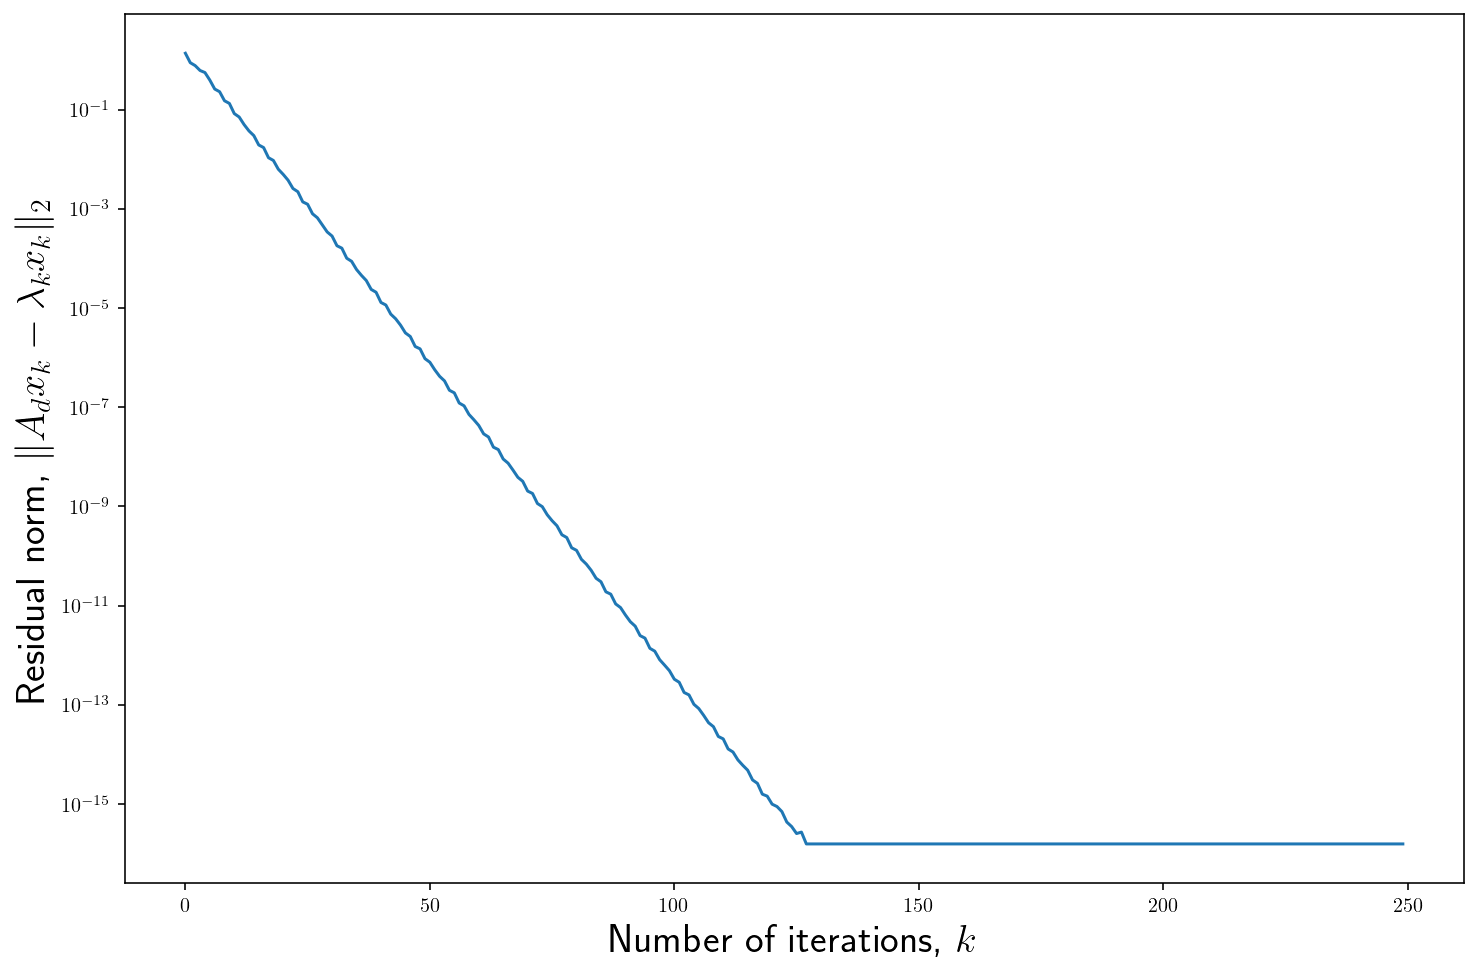

In [146]:
print(f'eigenvector: {x} eigenvalue: {l}')
plt.figure(figsize=(12, 8))
plt.xlabel("Number of iterations, $k$", fontsize=20)
plt.ylabel("Residual norm, $\|A_dx_k - \lambda_k x_k\|_2$", fontsize=20)
plt.semilogy(res);

In [130]:
def restore_invariant(G, d, p, r, u, v, op='insert'):
    out = G.sum(axis=1).reshape(-1)[u]
    r_new = ((1 - d) * p[v] - p[u] - d * r[u] + d * (u == p.argmax())) / d / out
    r[u] += r_new if op == 'insert' else - r_new
    return r

In [177]:
def sequential_push(G, d, p, r, eps):
    out = G.sum(axis=1).reshape(-1)
    def seq_push(u):
        p[u] += d * r[u]
        for i in G[:, u].nonzero():
            v = i[0]
            r[v] += (1 - d) * r[u] / out[v]
        r[u] = 0
    while max(r) > eps:
        seq_push(r.argmax())
    while min(r) < - eps:
        seq_push(r.argmin())
    return p, r

In [192]:
G = np.array([[0, 0, 0, 1],
             [1, 0, 0, 0],
             [1, 1, 0, 0],
             [0, 0, 1, 0]])

In [193]:
A = pagerank_matrix(sp.sparse.csr_matrix(G))
d = 0.5
L = spsplin.LinearOperator(A.shape, matvec=lambda x: pagerank_matvec(A, d, x))

p = np.zeros(A.shape[0])
s = G.sum(axis=0).argmax()
p[s] = 1

r = p * d

num_iter = 50
x, l, res = power_method(L, p, num_iter)
x /= x.sum()

In [194]:
p, r

(array([1., 0., 0., 0.]), array([0.5, 0. , 0. , 0. ]))

In [196]:
G[0, 1] = 1
G

array([[0, 1, 0, 1],
       [1, 0, 0, 0],
       [1, 1, 0, 0],
       [0, 0, 1, 0]])

In [197]:
p = np.array([1/2, 1/4, 3/16, 1/16])
r = np.array([1/16, 0, 0, 1/16])

In [198]:
restore_invariant(G, d, p, r, 0, 1, 'insert')

array([0.15625, 0.     , 0.     , 0.0625 ])

In [199]:
sequential_push(G, d, p, r, 0.1)

(array([0.578125, 0.25    , 0.1875  , 0.0625  ]),
 array([0.      , 0.078125, 0.      , 0.0625  ]))

eigenvector: [0.3245614 0.1754386 0.25      0.25     ] eigenvalue: 0.999999999997183


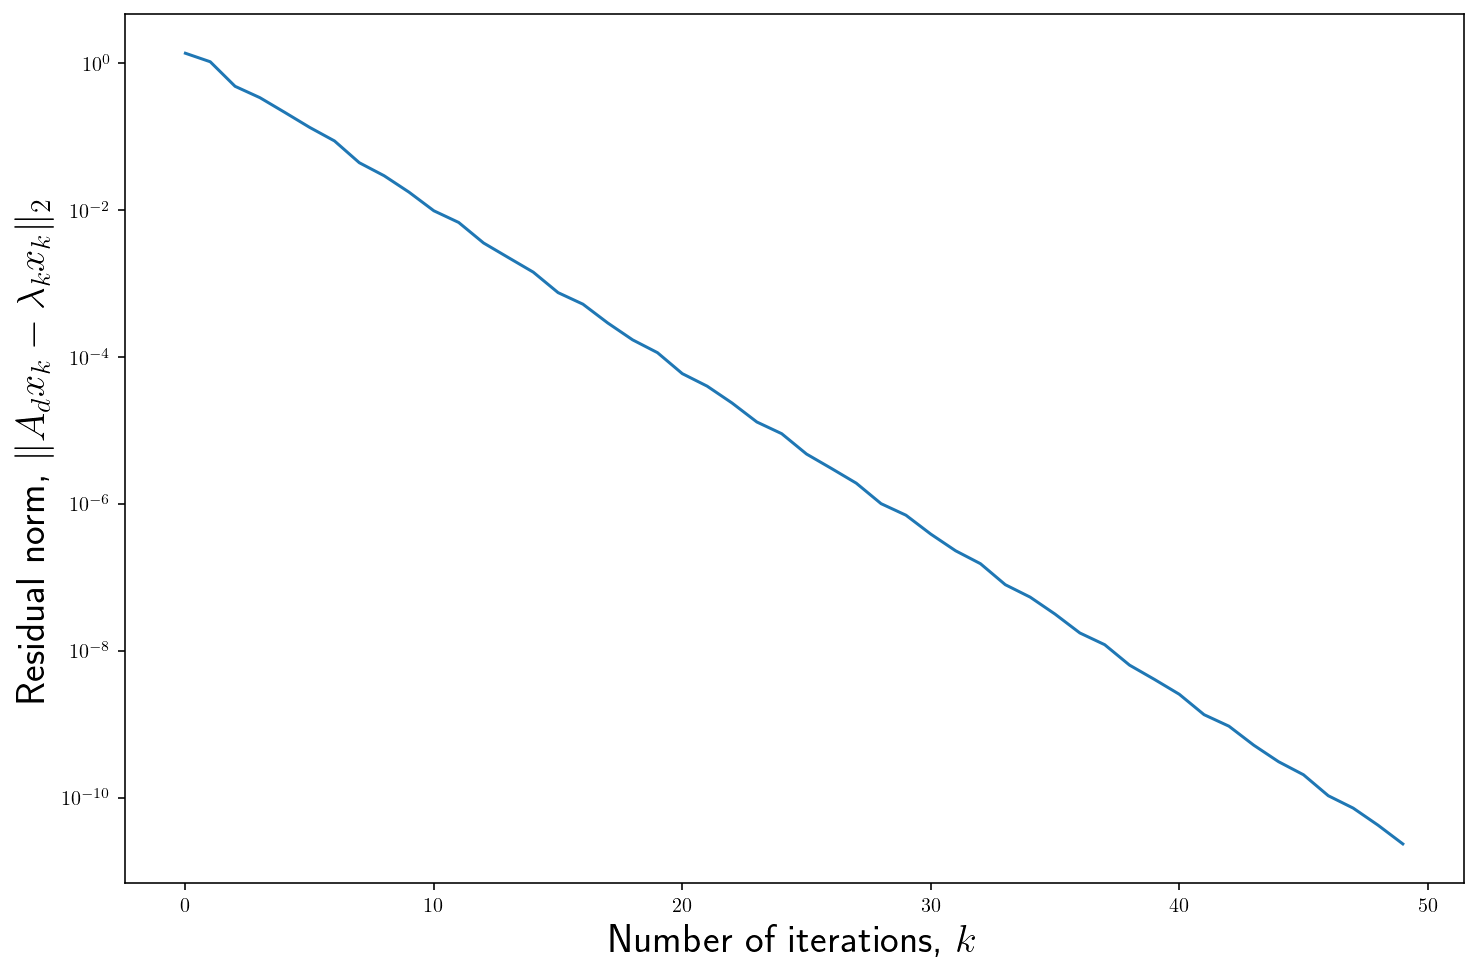

In [168]:
print(f'eigenvector: {x} eigenvalue: {l}')
plt.figure(figsize=(12, 8))
plt.xlabel("Number of iterations, $k$", fontsize=20)
plt.ylabel("Residual norm, $\|A_dx_k - \lambda_k x_k\|_2$", fontsize=20)
plt.semilogy(res);